Testing DIAObject indexing options:
- create separate partition for nightly DIAObject inserts, no indexing
- daily sweep of that partition into fully-indexed DIAObject table

In [1]:
%pylab inline
plt.style.use('bmh');

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
def do_plot(ds, name, y=['visit_real'], figsize = (8, 5)):
    ds.plot(y=y, style=['o', 'r+'], title=name, figsize=figsize)

def do_boxplot(ds, by_col_name, columns, title='', bin=100, figsize=(8, 4)):
    for col in columns:
        ds.boxplot(col, by=by_col_name, figsize=figsize, showmeans=True, sym='x', whis='range')
        x = ds.index
        y = ds[col]
        try:
            x = x/bin
            p = polyfit(x, y, 1)
            y = x*p[0] + p[1]
            label = "fit: {:.3f} + {:.3f}*visit/1000".format(p[1], p[0])
            # x + 1 is needed because boxplot draws in strange coordinates
            plt.plot(x+1, y, "--g", label=label)
            plt.legend()
        except:
            pass

        plt.title("")
        plt.suptitle(title + ": " + col)

def do_plots(file_name, title, bin=100, filter_count=True, bad_visits=None, 
             what=['scatter', 'counts', 'box'], time='visit_real'):
    ds = pd.read_csv(file_name, header=0, index_col='visit')
    if filter_count:
        # filter out records doing COUNT(*) which takes long time
        dscount = ds[ds.src_count.notnull()]
        ds = ds[ds.src_count.isnull()]
    if bad_visits:
        ds.drop(bad_visits, inplace=True)
    ds.fillna(0, axis=1, inplace=True)
    ds = ds[:27000]
    
    # do "scatter" plot
    if 'scatter' in what:
        do_plot(ds, title, y=[time])
    if 'counts' in what:
        do_plot(dscount, title, y=['obj_count', 'src_count'], figsize=(8, 4))
    
    # box plots
    if 'box' in what:
        col_name = 'visit/' + str(bin)
        ds[col_name] = np.array(ds.index/bin, dtype=int64)
        do_boxplot(ds, col_name, [time], bin=bin, title=title)

    return ds

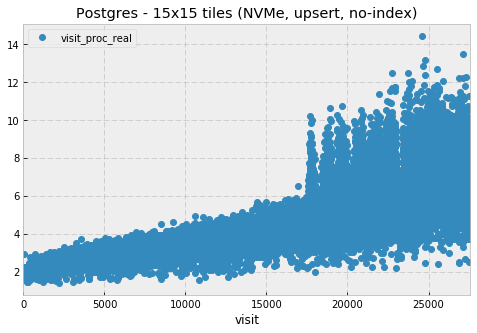

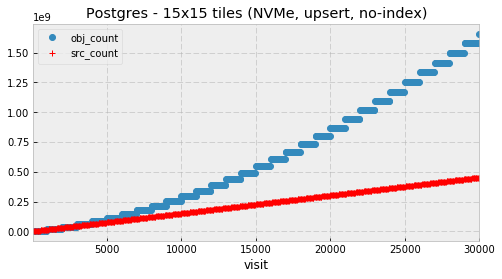

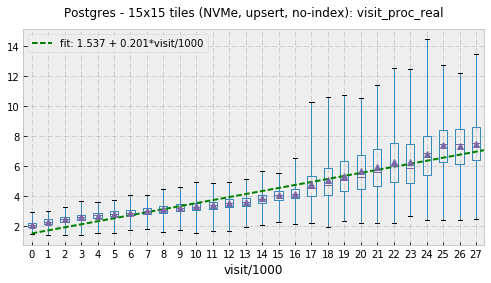

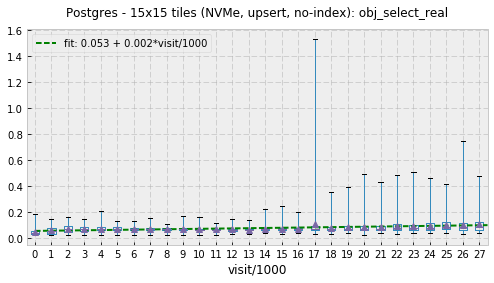

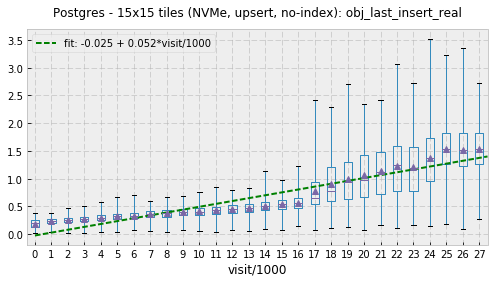

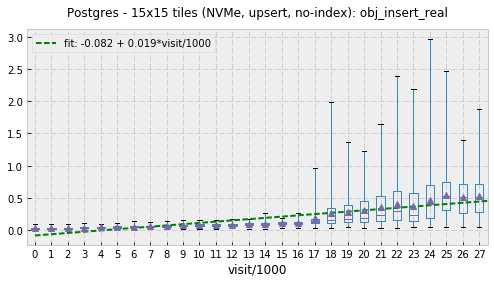

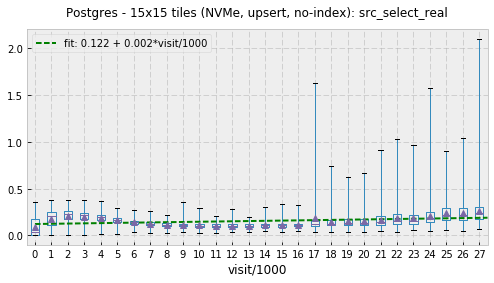

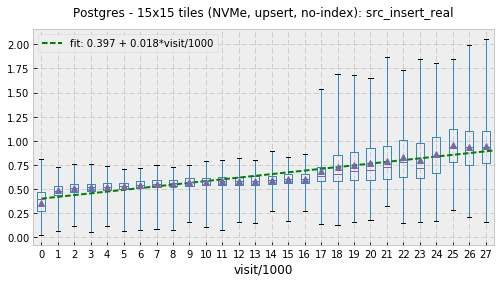

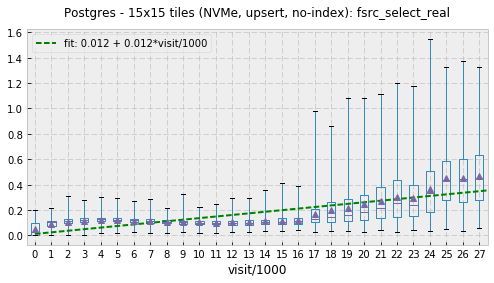

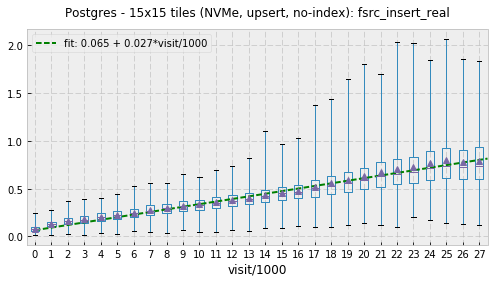

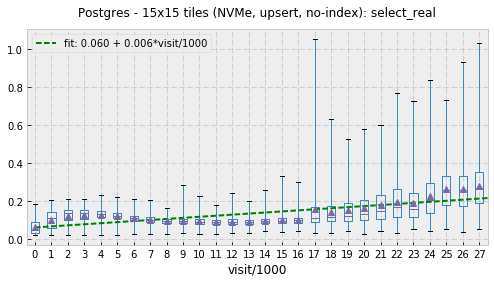

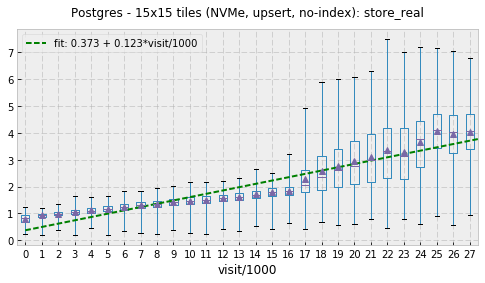

In [4]:
ds = do_plots("data/dm-10092-l1db-pg-15x15-nvme-objnightly-01.csv.gz",
              "Postgres - 15x15 tiles (NVMe, upsert, no-index)", 
              bin=1000, time='visit_proc_real')
do_boxplot(ds, 'visit/1000', 
           ['obj_select_real', 'obj_last_insert_real',
            'obj_insert_real', 'src_select_real', 'src_insert_real',
            'fsrc_select_real', 'fsrc_insert_real', 'select_real', 'store_real'
           ],
           "Postgres - 15x15 tiles (NVMe, upsert, no-index)", bin=1000)

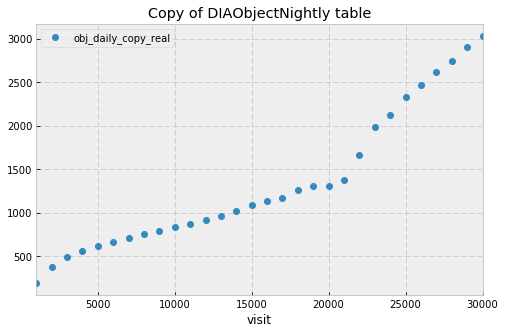

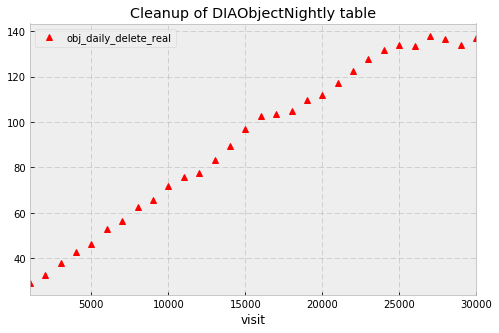

In [5]:
ds = pd.read_csv("data/dm-10092-l1db-pg-15x15-nvme-objnightly-daily-01.csv.gz", header=0, index_col='visit')
ds.plot(y="obj_daily_copy_real", style='o', title="Copy of DIAObjectNightly table", figsize=(8,5));
ds.plot(y="obj_daily_delete_real", style='r^', title="Cleanup of DIAObjectNightly table", figsize=(8,5));